In [1]:
from src.experiments.common import Experiment, Run, get_run_from_path
from pathlib import Path
import matplotlib.pyplot as plt
import plotly.express as px
import pandas as pd
import seaborn as sns
experiment = Experiment("sghmc_gradients")

In [2]:
run = get_run_from_path(Path("../experiment_results/sghmc_gradients/2021-10-18/10-55-19").resolve())

In [3]:
variance_estimates = run.runs[5].load_result("variance_estimates")
global_steps = run.runs[5].load_result("global_steps")

In [4]:
import torch
def subsample(tensor, n, dim=0, seed=123):
    with torch.random.fork_rng():
        torch.manual_seed(seed)
        index = torch.randperm(tensor.shape[dim])[:n]
    return tensor.index_select(dim, index), index

In [5]:
n_steps = 100
start = (len(global_steps) - n_steps) // 2
stop = len(global_steps) - start
slice_ = slice(start, stop)
step = global_steps[slice_]

In [6]:
variance_inter_batch = variance_estimates["variance_inter_batch"][slice_]
variance_estimated = variance_estimates["variance_estimated"][slice_]

variance_inter_batch, sample_idx = subsample(variance_inter_batch, 500, 1)
variance_estimated = variance_estimated[:, sample_idx]


In [7]:
is_zero = variance_estimates["variance_estimated"].isclose(torch.tensor(0.0)).all(0)
is_zero |= variance_estimates["variance_inter_batch"].isclose(torch.tensor(0.0)).all(0)

non_zero_index = (~is_zero).nonzero().flatten()
plot_idx = non_zero_index[torch.randperm(len(non_zero_index))[:9]]

plot_data = pd.concat(
    [
        pd.DataFrame(
            {
                "Interbatch variance": variance_estimates["variance_inter_batch"][
                    :, idx
                ],
                "Estimated variance": variance_estimates["variance_estimated"][:, idx],
            },
            index=pd.MultiIndex.from_product(
                [[idx.item()], global_steps], names=("index", "step")
            ),
        )
        for idx in plot_idx
    ]
).assign(step_mod_100=lambda x: x.index.get_level_values("step") % 100)


In [8]:
plot_data

Interbatch variance  Estimated variance  step_mod_100
index step                                                        
903   9               629.230957          757.184814             9
      19              671.049500          757.184814            19
      29             1053.381958          757.184814            29
      39             1374.912109          757.184814            39
      49             1792.920654          757.184814            49
...                          ...                 ...           ...
48    79959           203.916885          324.997040            59
      79969           202.267197          324.997040            69
      79979           102.988518          324.997040            79
      79989            73.013222          324.997040            89
      79999            73.978134          324.997040            99

[72000 rows x 3 columns]

In [23]:
import rpy2.robjects as robjects
from rpy2.robjects.lib import ggplot2
from rpy2.robjects import pandas2ri
from rpy2.robjects.packages import importr
from rpy2.robjects.conversion import localconverter


In [ ]:
pd.Series(plot_idx).map(get_data)

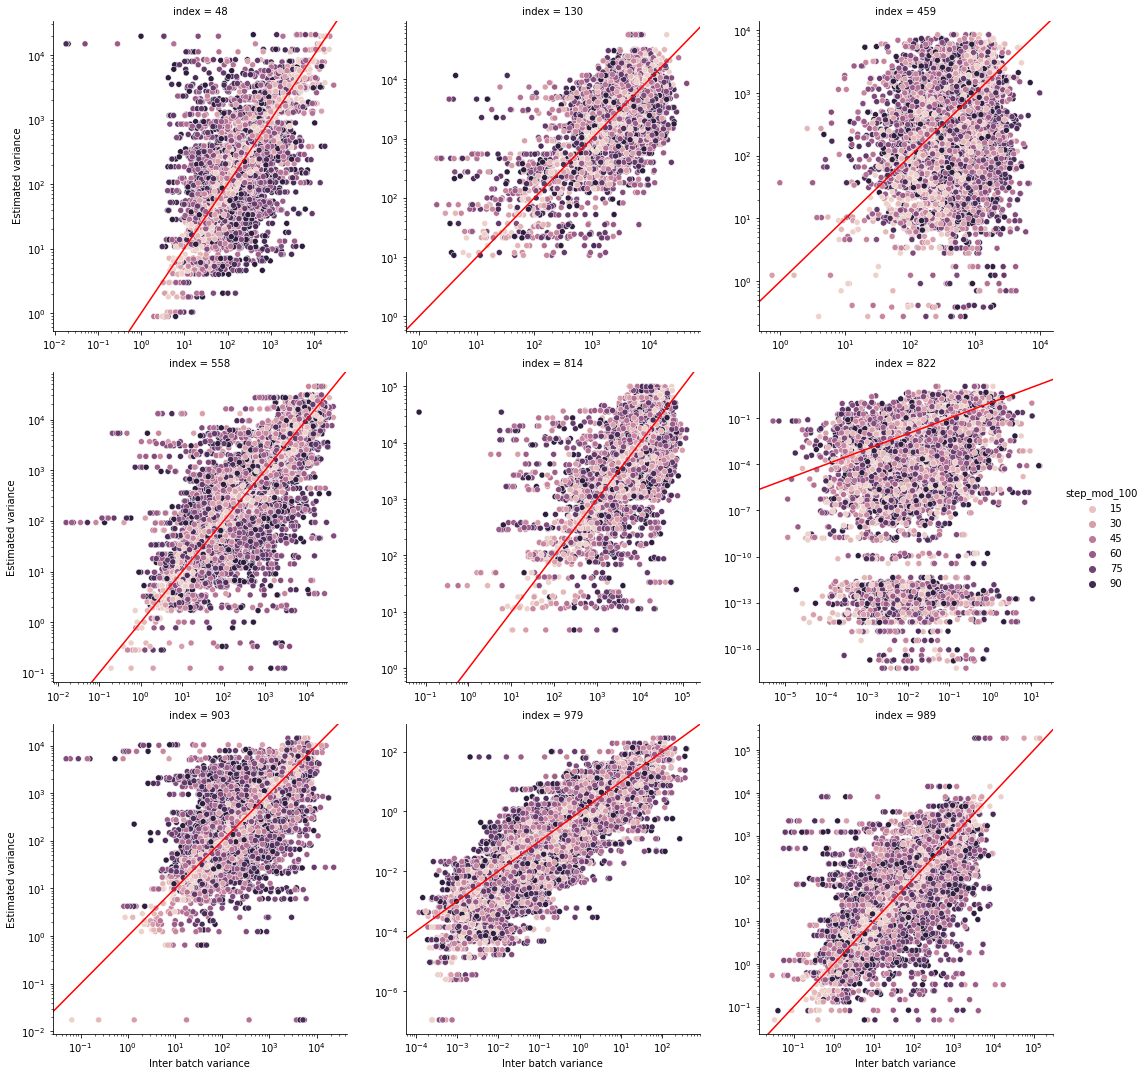

In [15]:
def get_data(idx):

    return pd.DataFrame(
        {
            "Inter batch variance": variance_estimates["variance_inter_batch"][:, idx],
            "Estimated variance": variance_estimates["variance_estimated"][:, idx],
        },
        index=pd.MultiIndex.from_product(
            [[idx.item()], global_steps], names=("index", "step")
        ),
    )


fg = (
    pd.concat(map(get_data, plot_idx))
    .assign(step_mod_100=lambda x: x.index.get_level_values("step") % 100)
    .reset_index()
    .sample(frac=1.)
    .pipe(
        (sns.relplot, "data"),
        x="Inter batch variance",
        y="Estimated variance",
        col="index",
        col_wrap=3,
        hue="step_mod_100",
        facet_kws={"sharey": False, "sharex": False},
    )
)

fg.set(xscale="log")
fg.set(yscale="log")
for ax in fg.axes.flatten():
    ax.axline((0, 0), (1, 1), color="red")

In [43]:
import rpy2.robjects.lib.ggplot2 as ggplot2

data = (
    pd.concat(map(get_data, plot_idx))
    .assign(step_mod_100=lambda x: x.index.get_level_values("step") % 100)
    .reset_index()
    .sample(frac=1.)
)
with localconverter(robjects.default_converter + pandas2ri.converter):
    data_r = robjects.conversion.py2rpy(data)

pp = (
    ggplot2.ggplot(data_r) 
    + ggplot2.aes_string(x='`Inter batch variance`', y='`Estimated variance`', col='step_mod_100')
    + ggplot2.geom_point()
    + ggplot2.facet_wrap("~index", scales="free")
    + ggplot2.scale_y_continuous(trans="log10")
    + ggplot2.scale_x_continuous(trans="log10")
)
pp.save("fdsfdsf.pdf")

R[write to console]: Saving 7 x 7 in image



In [ ]:
(
    plot_data.assign(
        rel_diff=lambda x: (
            (x["Interbatch variance"] - x["Estimated variance"])
            / x["Interbatch variance"]
        ).abs()
    )
    .reset_index("index")
    .groupby(["step_mod_100", "index"])
    .mean()
    .pipe((sns.relplot, "data"), x="step_mod_100", y="rel_diff")
)
plt.yscale("log")


In [ ]:
plot_data = (
    pd.merge(
        pd.DataFrame(variance_estimated.numpy(), index=step)
        .reset_index()
        .melt(id_vars="index", value_name="variance_estimated"),
        pd.DataFrame(variance_inter_batch.numpy(), index=step)
        .reset_index()
        .melt(id_vars="index", value_name="variance_inter_batch"),
    )
    .assign(step_mod_100=lambda x: x["index"] % 100)
    .loc[lambda x: (x.variance_estimated > 1e-8) & (x.variance_inter_batch > 1e-8)]
)


In [ ]:
plot_data

In [ ]:
import numpy as np
import matplotlib.ticker as mticker
sns.set(style = "whitegrid")

fig = plt.figure(figsize=(10,8))
ax = plt.subplot(projection="3d")
x, y, z, c = plot_data[["index", "variance_inter_batch", "variance_estimated", "step_mod_100"]].to_numpy().T
def log_tick_formatter(val, pos=None):
    return f"10^{int(val):d}"
    
sc = ax.scatter(x, np.log10(y), np.log10(z), c=c)
ax.yaxis.set_major_formatter(mticker.FuncFormatter(log_tick_formatter))
ax.zaxis.set_major_formatter(mticker.FuncFormatter(log_tick_formatter))
ax.view_init(20, -30)
ax.set_xlabel("Step")
ax.set_ylabel("Estimated variance")
ax.set_zlabel("Interbatch variance")
plt.colorbar(sc)
plt.show()
